In [1]:
from dask.distributed import Client, SSHCluster

machine1 = '10.67.22.152'
machine2 = '10.67.22.250'
#machine3 = '10.67.22.254'

In [2]:
import os
import dask
import ast
import json
from dask import delayed, compute
import io
from dask.distributed import LocalCluster
from dask import delayed
import dask.array as da
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client
import dask.bag as db
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
import dask.dataframe as ddf
import csv
import numpy as np

In [94]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from matplotlib.colors import LinearSegmentedColormap

In [4]:
def load_json_data(filename):
    
    with open(os.path.join(folder_path, filename), 'r') as file:
        json_data = json.load(file)
        
    return json_data

def extract_titles(record):
    
    ID = record['paper_id']
    title = record['metadata']['title']
    title_tokens = word_tokenize(record['metadata']['title'])
    title_tokens_clean = [word.lower() for word in title_tokens\
                          if not word.lower() in stopwords.words('english') + ['use','used']\
                         and word.isalpha()] 
    
    return{'ID': ID,
          'title': title,
          'title_tokens': title_tokens_clean}

# Calculate the embedding matrix for a line
def calculate_embedding_matrix(line):
    keys = line
    values = [model.get(key) for key in keys if model.get(key)]
    matrix = [vector  for vector in values]
    return matrix

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    line_count = 0  # Track the number of lines read
    for line in fin:
        if line_count >= 1000:
            break  # Exit the loop after 100000 lines
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
        line_count += 1
    fin.close()  # Close the file after reading
    return data

In [97]:
folder_path = '/mnt/covid/data/papers1'
file_list = os.listdir(folder_path)

# Create a Dask Bag to store the imported data
bag = db.from_sequence(file_list).map(load_json_data)

titles = bag.map(extract_titles)
model = load_vectors('wiki.en.vec')

In [76]:
npartitions = [1 ,2,  4 , 8 , 16,  32 , 64 , 128, 256]

In [98]:
nworkers = [1 , 2 , 4 , 8 , 14]

In [99]:
def time_task3(npartitions):
    
    i = time.time()
    
    df_title = titles.to_dataframe(meta=pd.DataFrame(columns = ['ID', 'title', 'title_tokens' ])).repartition(npartitions)
    
    df_title.persist()
    
    df_title['embedding matrix'] = df_title['title_tokens'].map(calculate_embedding_matrix)
    
    df_title.persist()
    
    df_title.compute()
    
    f = time.time()
    
    return (f-i)

In [100]:
durations = np.full((len(npartitions) , len(nworkers)) , np.nan)  # Initialize an empty matrix
for i , n in enumerate(nworkers):

    cluster = SSHCluster([machine1, machine1, machine2],
                         scheduler_options={"port": 0, "dashboard_address": ":9091"},
                         worker_options={"n_workers": n})

    client = Client(cluster)

    for j , nps in enumerate(npartitions):
        duration = time_task3(nps)
        durations[j][i] = duration 
        print('For', nps, 'number of partitions and', n * 2 , 'number of workers, the runtime is:', duration, 'seconds')

    client.close()
    cluster.close()
    client.shutdown()


2023-07-06 08:50:52,426 - distributed.deploy.ssh - INFO - 2023-07-06 08:50:52,422 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-07-06 08:50:52,439 - distributed.deploy.ssh - INFO - /root/miniconda3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 9091 is already in use.
2023-07-06 08:50:52,440 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-06 08:50:52,441 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 36049 instead
2023-07-06 08:50:52,443 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-06 08:50:52,512 - distributed.deploy.ssh - INFO - 2023-07-06 08:50:52,511 - distributed.scheduler - INFO - State start
2023-07-06 08:50:52,533 - distributed.deploy.ssh - INFO - 2023-07-06 08:50:52,531 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/schedule

For 1 number of partitions and 2 number of workers, the runtime is: 14.71128535270691 seconds
For 2 number of partitions and 2 number of workers, the runtime is: 9.781970500946045 seconds
For 4 number of partitions and 2 number of workers, the runtime is: 8.539210796356201 seconds
For 8 number of partitions and 2 number of workers, the runtime is: 8.830886125564575 seconds
For 16 number of partitions and 2 number of workers, the runtime is: 9.104747533798218 seconds
For 32 number of partitions and 2 number of workers, the runtime is: 10.183698654174805 seconds
For 64 number of partitions and 2 number of workers, the runtime is: 12.111181259155273 seconds
For 128 number of partitions and 2 number of workers, the runtime is: 15.978439569473267 seconds
For 256 number of partitions and 2 number of workers, the runtime is: 21.851845741271973 seconds


2023-07-06 08:52:51,407 - distributed.deploy.ssh - INFO - 2023-07-06 08:52:51,405 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-07-06 08:52:51,416 - distributed.deploy.ssh - INFO - /root/miniconda3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 9091 is already in use.
2023-07-06 08:52:51,417 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-06 08:52:51,421 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 37457 instead
2023-07-06 08:52:51,423 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-06 08:52:51,467 - distributed.deploy.ssh - INFO - 2023-07-06 08:52:51,466 - distributed.scheduler - INFO - State start
2023-07-06 08:52:51,475 - distributed.deploy.ssh - INFO - 2023-07-06 08:52:51,474 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.152:42245
2023-07-06 08:52:52,951 - d

For 1 number of partitions and 4 number of workers, the runtime is: 7.716080665588379 seconds
For 2 number of partitions and 4 number of workers, the runtime is: 5.634270191192627 seconds
For 4 number of partitions and 4 number of workers, the runtime is: 5.263737916946411 seconds
For 8 number of partitions and 4 number of workers, the runtime is: 5.551932096481323 seconds
For 16 number of partitions and 4 number of workers, the runtime is: 5.724812030792236 seconds
For 32 number of partitions and 4 number of workers, the runtime is: 6.553428649902344 seconds
For 64 number of partitions and 4 number of workers, the runtime is: 7.7463483810424805 seconds
For 128 number of partitions and 4 number of workers, the runtime is: 10.613417625427246 seconds
For 256 number of partitions and 4 number of workers, the runtime is: 15.200939416885376 seconds


2023-07-06 08:54:07,637 - distributed.deploy.ssh - INFO - 2023-07-06 08:54:07,635 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-07-06 08:54:07,646 - distributed.deploy.ssh - INFO - /root/miniconda3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 9091 is already in use.
2023-07-06 08:54:07,647 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-06 08:54:07,649 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 40685 instead
2023-07-06 08:54:07,651 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-06 08:54:07,699 - distributed.deploy.ssh - INFO - 2023-07-06 08:54:07,698 - distributed.scheduler - INFO - State start
2023-07-06 08:54:07,709 - distributed.deploy.ssh - INFO - 2023-07-06 08:54:07,708 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.152:33595
2023-07-06 08:54:09,280 - d

For 1 number of partitions and 8 number of workers, the runtime is: 7.105339050292969 seconds
For 2 number of partitions and 8 number of workers, the runtime is: 4.29346776008606 seconds
For 4 number of partitions and 8 number of workers, the runtime is: 3.8620388507843018 seconds
For 8 number of partitions and 8 number of workers, the runtime is: 4.851135730743408 seconds
For 16 number of partitions and 8 number of workers, the runtime is: 4.2655510902404785 seconds
For 32 number of partitions and 8 number of workers, the runtime is: 4.776782035827637 seconds
For 64 number of partitions and 8 number of workers, the runtime is: 6.113507270812988 seconds
For 128 number of partitions and 8 number of workers, the runtime is: 8.475892305374146 seconds
For 256 number of partitions and 8 number of workers, the runtime is: 13.701943159103394 seconds


2023-07-06 08:55:11,890 - distributed.deploy.ssh - INFO - 2023-07-06 08:55:11,888 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-07-06 08:55:11,898 - distributed.deploy.ssh - INFO - /root/miniconda3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 9091 is already in use.
2023-07-06 08:55:11,899 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-06 08:55:11,901 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 40331 instead
2023-07-06 08:55:11,902 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-06 08:55:11,959 - distributed.deploy.ssh - INFO - 2023-07-06 08:55:11,959 - distributed.scheduler - INFO - State start
2023-07-06 08:55:11,968 - distributed.deploy.ssh - INFO - 2023-07-06 08:55:11,967 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.152:45009
2023-07-06 08:55:13,500 - d

For 1 number of partitions and 16 number of workers, the runtime is: 8.018615245819092 seconds
For 2 number of partitions and 16 number of workers, the runtime is: 4.420866250991821 seconds
For 4 number of partitions and 16 number of workers, the runtime is: 4.875039577484131 seconds
For 8 number of partitions and 16 number of workers, the runtime is: 4.681048393249512 seconds
For 16 number of partitions and 16 number of workers, the runtime is: 4.926144361495972 seconds
For 32 number of partitions and 16 number of workers, the runtime is: 5.323199033737183 seconds
For 64 number of partitions and 16 number of workers, the runtime is: 6.0197694301605225 seconds
For 128 number of partitions and 16 number of workers, the runtime is: 8.442176580429077 seconds
For 256 number of partitions and 16 number of workers, the runtime is: 13.24576735496521 seconds


2023-07-06 08:56:19,396 - distributed.deploy.ssh - INFO - 2023-07-06 08:56:19,393 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2023-07-06 08:56:19,414 - distributed.deploy.ssh - INFO - /root/miniconda3/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 9091 is already in use.
2023-07-06 08:56:19,416 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2023-07-06 08:56:19,420 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 44197 instead
2023-07-06 08:56:19,421 - distributed.deploy.ssh - INFO - warnings.warn(
2023-07-06 08:56:19,604 - distributed.deploy.ssh - INFO - 2023-07-06 08:56:19,603 - distributed.scheduler - INFO - State start
2023-07-06 08:56:19,636 - distributed.deploy.ssh - INFO - 2023-07-06 08:56:19,634 - distributed.scheduler - INFO -   Scheduler at:  tcp://10.67.22.152:36949
2023-07-06 08:56:21,615 - d

For 1 number of partitions and 28 number of workers, the runtime is: 10.604439973831177 seconds
For 2 number of partitions and 28 number of workers, the runtime is: 5.122525453567505 seconds
For 4 number of partitions and 28 number of workers, the runtime is: 4.957530498504639 seconds
For 8 number of partitions and 28 number of workers, the runtime is: 5.16044020652771 seconds
For 16 number of partitions and 28 number of workers, the runtime is: 5.354456424713135 seconds
For 32 number of partitions and 28 number of workers, the runtime is: 7.486174583435059 seconds
For 64 number of partitions and 28 number of workers, the runtime is: 6.888522148132324 seconds
For 128 number of partitions and 28 number of workers, the runtime is: 9.034978151321411 seconds
For 256 number of partitions and 28 number of workers, the runtime is: 15.528822660446167 seconds


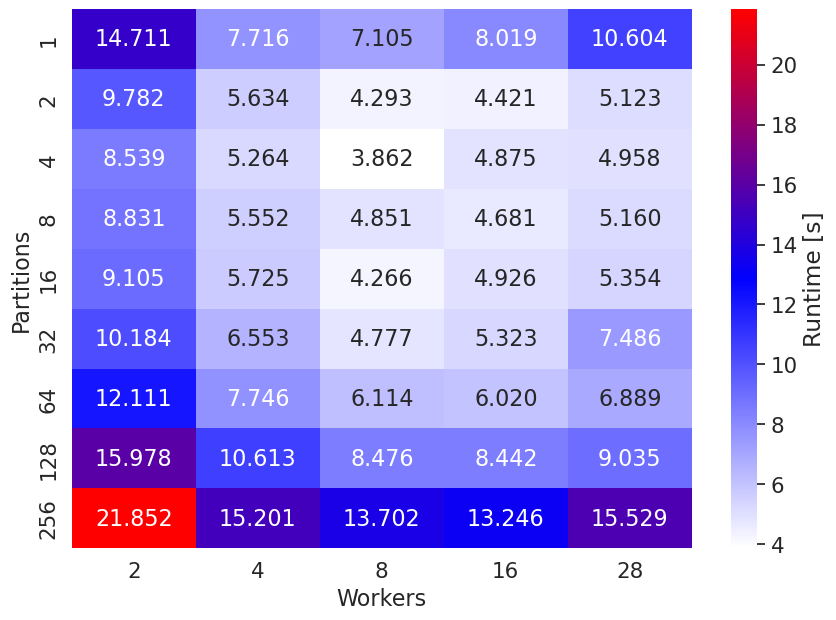

2023-07-06 08:59:00,060 - distributed.deploy.cluster - WARNING - Failed to sync cluster info multiple times - perhaps there's a connection issue? Error:
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.10/site-packages/distributed/comm/tcp.py", line 491, in connect
    stream = await self.client.connect(
  File "/root/miniconda3/lib/python3.10/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.10/asyncio/tasks.py", line 456, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.10/site-packages/distributed/comm/core.py", line 336, in connect
    comm = await 

In [101]:
reshaped_durations = np.array(durations).reshape(len(npartitions), len(nworkers))
df_cm = pd.DataFrame(reshaped_durations, index=npartitions, columns=np.array(nworkers)*2)


# Plot the heatmap
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)  # for label size

# Define the custom color map from white to blue and then red
colors = ["white", "blue", "red"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt=".3f",
            cbar_kws={'label': 'Runtime [s]'}, cmap=cmap)
plt.xlabel('Workers', fontsize=16)
plt.ylabel('Partitions', fontsize=16)
plt.show()
plt.style.use('default')


In [22]:
client.close()
cluster.close()

In [23]:
client.shutdown()